# Signal processing

This notebook provides an overview of the functions provided by the elephant `signal_processing` module.

In [200]:
import neo
import numpy as np
import quantities as pq
from elephant.signal_processing import *
from elephant.datasets import download_datasets
import matplotlib.pyplot as plt

All measures presented here require one or two `neo.AnalogSignal` objects as input. For this, we use an electrophysiology recording, and this data file contains one trial of an experiment.

In [201]:
# TODO: this is just for development and using local data, delete before merging
from pathlib import Path
filepath = Path('~/gin/elephant-data/tutorials/tutorial_signal_processing/data/i140703-001_single_trial.nix').expanduser()

# Download data
# repo_path='tutorials/tutorial_signal_processing/data/i140703-001_single_trial.nix'
# filepath=download_datasets(repo_path)


In [202]:
with neo.NixIO(f"{filepath}", 'ro') as file:
    block = file.read_block()

signals = block.segments[0].analogsignals[0]

## 1. z-scoring

Here, we use the `zscore` function  to normalize the signal. The `inplace` option is set to `False` to avoid overwriting the original signal, as it is required for subsequent examples.

In [203]:
signal = signals[:,1]

z_scored_signal = zscore(signal, inplace=False)

The result is the z-scored signal, as shown in the plots below.

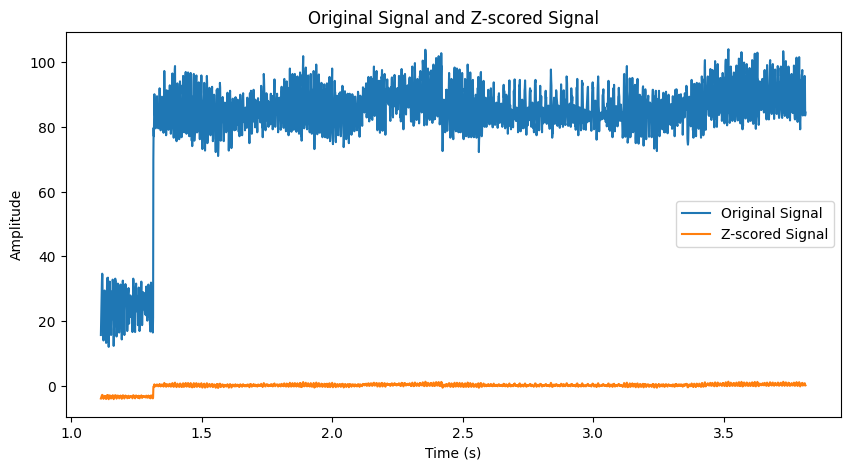

In [204]:
# Plot the original signal
plt.figure(figsize=(10, 5))
plt.plot(signal.times, signal, label='Original Signal')

# Plot the z-scored signal
plt.plot(z_scored_signal.times, z_scored_signal, label='Z-scored Signal')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original Signal and Z-scored Signal')
plt.legend()

# Show the plot
plt.show()

## 2. cross-correlation

We use the `cross_correlation_function` from the Elephant library to compute the cross-correlation between two signals. Specifically, we define the pair `[0, 1]` as the channel pair for cross-correlation.

In [205]:
signal = signals
signal = signal.time_shift(-signal.t_start)
# Compute cross-correlation
rho = cross_correlation_function(signal, [0, 1], scaleopt = 'unbiased', hilbert_envelope=False)

Cross-correlation helps us analyze the temporal relationship between two signals, identifying potential time delays or dependencies. The following plot aids in understanding the interaction between the two signals.

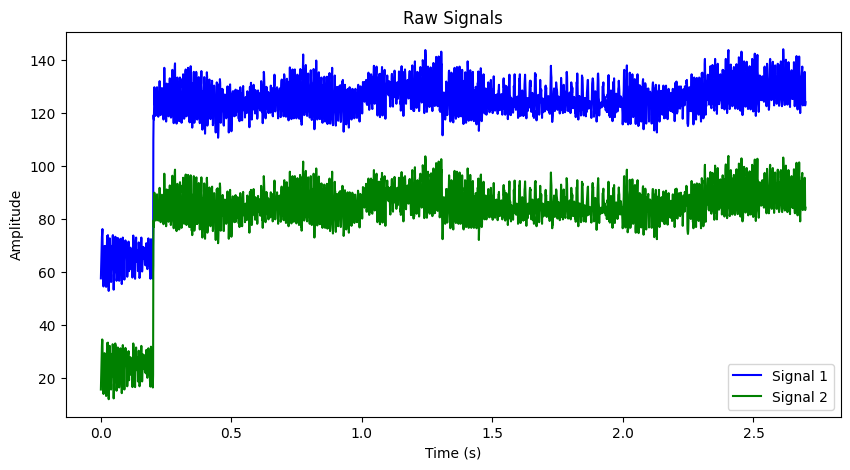

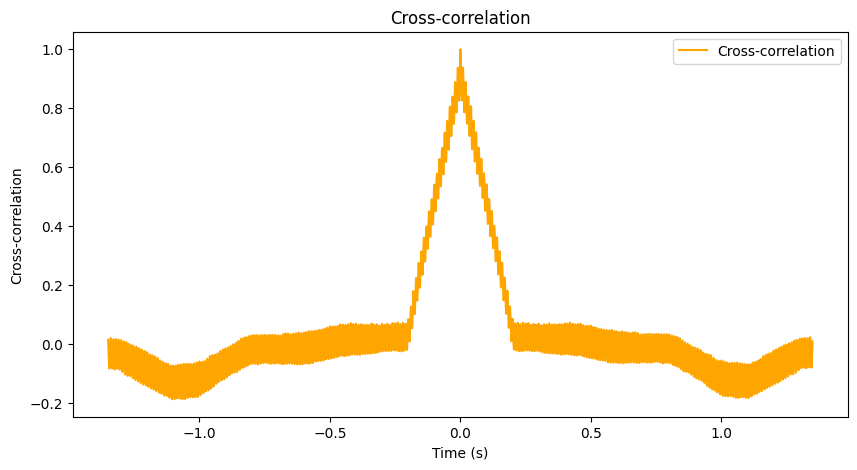

In [206]:
# Plot the two raw signals
plt.figure(figsize=(10, 5))
plt.plot(signal.times, signal[:, 0], label='Signal 1', color='blue')
plt.plot(signal.times, signal[:, 1], label='Signal 2', color='green')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Raw Signals')
plt.legend()
plt.show()

# Plot the cross-correlation and its envelope
plt.figure(figsize=(10, 5))
plt.plot(rho.times, rho, label='Cross-correlation', color='orange')

plt.xlabel('Time (s)')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation')
plt.legend()
plt.show()

## 3. Butterworth Filtering

In this section, we apply a Butterworth filter to the signal to isolate a relevant frequency range for our analysis. The filter is defined by specifying a `highpass` and `lowpass` frequency. The resulting filtered signal is visualized in the plot below, alongside the original signal for comparison.

In [207]:
signal = signals[:,1]
filtered_signal = butter(signal,lowpass_frequency=50*pq.Hz, highpass_frequency=250.0 * pq.Hz)

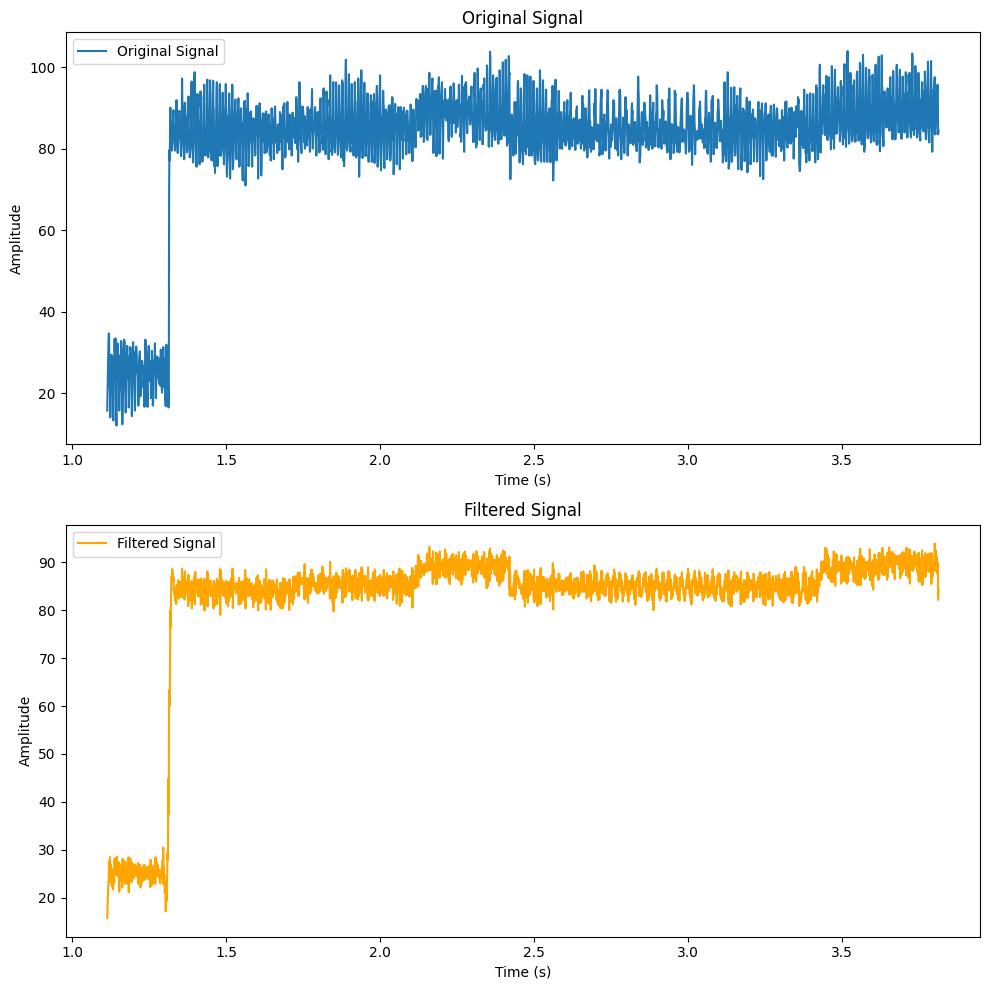

In [208]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot the original signal
axs[0].plot(signal.times, signal, label='Original Signal')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Original Signal')
axs[0].legend()

# Plot the filtered signal
axs[1].plot(filtered_signal.times, filtered_signal, label='Filtered Signal', color='orange')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Filtered Signal')
axs[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## 4. Wavelet transformation

In the following example, we apply the wavelet transform to the signal and plot the result. The wavelet used is a Morlet wavelet, and we define the frequency, which serves as the center frequency for the Morlet wavelet.

In [209]:
signal = signals[:,1]
transformed_signal = wavelet_transform(signal, frequency=50)
transformed_signal = neo.AnalogSignal(transformed_signal, units='mV', t_start=signal.t_start, sampling_rate=signal.sampling_rate)

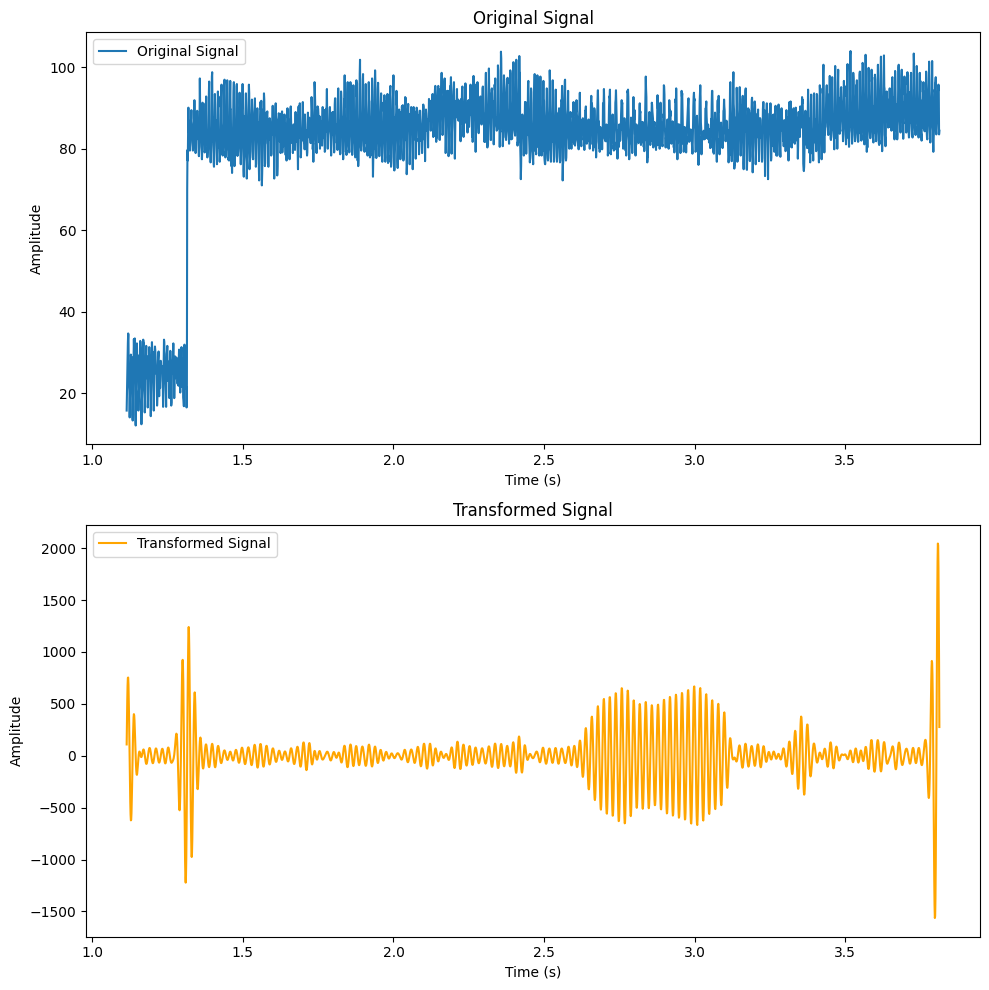

In [210]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot the original signal
axs[0].plot(signal.times, signal, label='Original Signal')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Original Signal')
axs[0].legend()

# Plot the filtered signal
axs[1].plot(transformed_signal.times, transformed_signal, label='Transformed Signal', color='orange')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Transformed Signal')
axs[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## 5. Hilbert transform

In the following cells, we use the `hilbert` function to apply the Hilbert transform to the signal. This transform generates the complex analytic signal, from which we can compute the amplitude and angle in radians using `np.abs` and `np.angle`, respectively. By default, the function applies 'nextpow' zero-padding to zero-pad the signal to the next length that is a power of 2.

In [211]:
signal = signals[:,1]
analytic_signal = hilbert(signal, padding='nextpow')
# Compute angles in radians
angles = np.angle(analytic_signal, deg=False)
# Compute amplitudes
amplitudes = np.abs(analytic_signal)

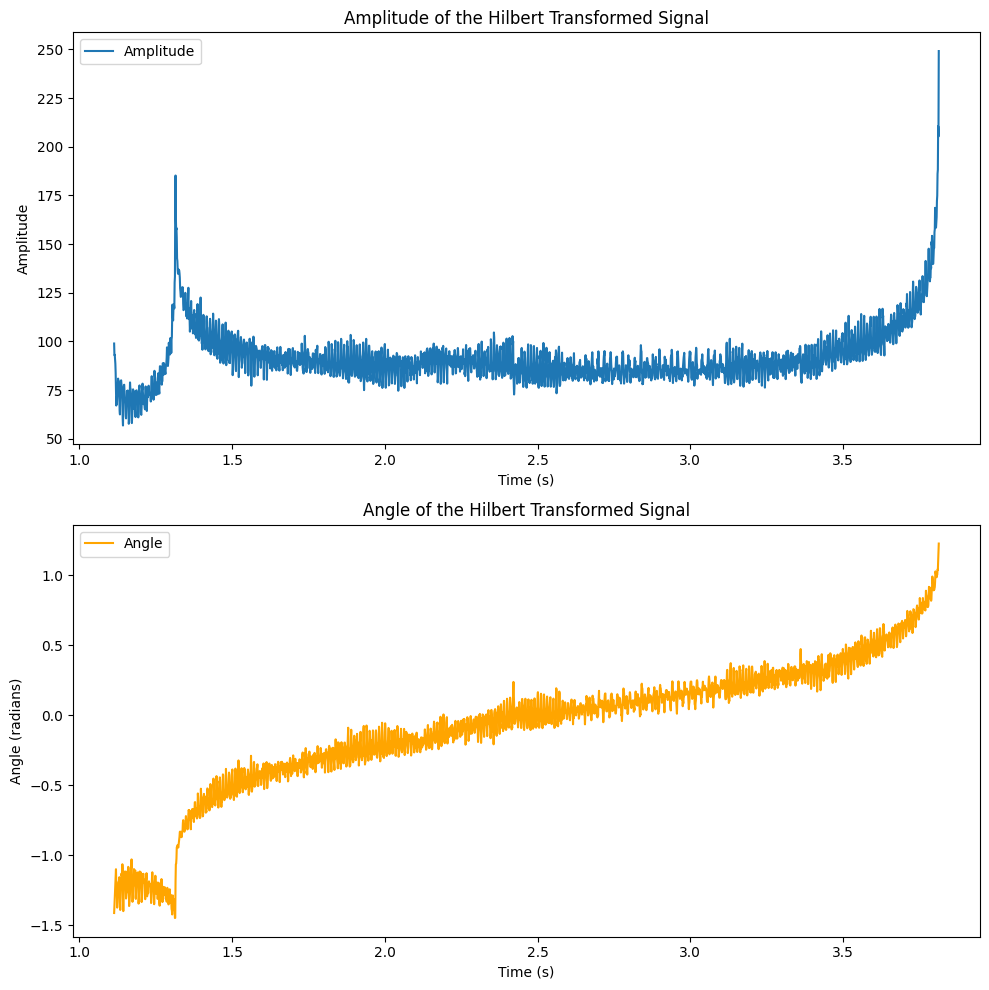

In [212]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot the amplitudes
axs[0].plot(signal.times, amplitudes, label='Amplitude')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Amplitude of the Hilbert Transformed Signal')
axs[0].legend()

# Plot the angles
axs[1].plot(signal.times, angles, label='Angle', color='orange')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Angle (radians)')
axs[1].set_title('Angle of the Hilbert Transformed Signal')
axs[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## 6. Rectified area under the curve (RAUC)

In the following lines of code, we calculate the rectified area under the curve (RAUC) for the signal. The baseline is set to the median, which is subtracted from the signal before calculating the RAUC. This process helps in normalizing the signal and analyzing its rectified area. The plots below shows the results.

In [213]:
signal = signals[:,1]
bin_duration = 0.1 * pq.s
derivative_of_signal = rauc(signal, baseline='median', bin_duration=bin_duration)

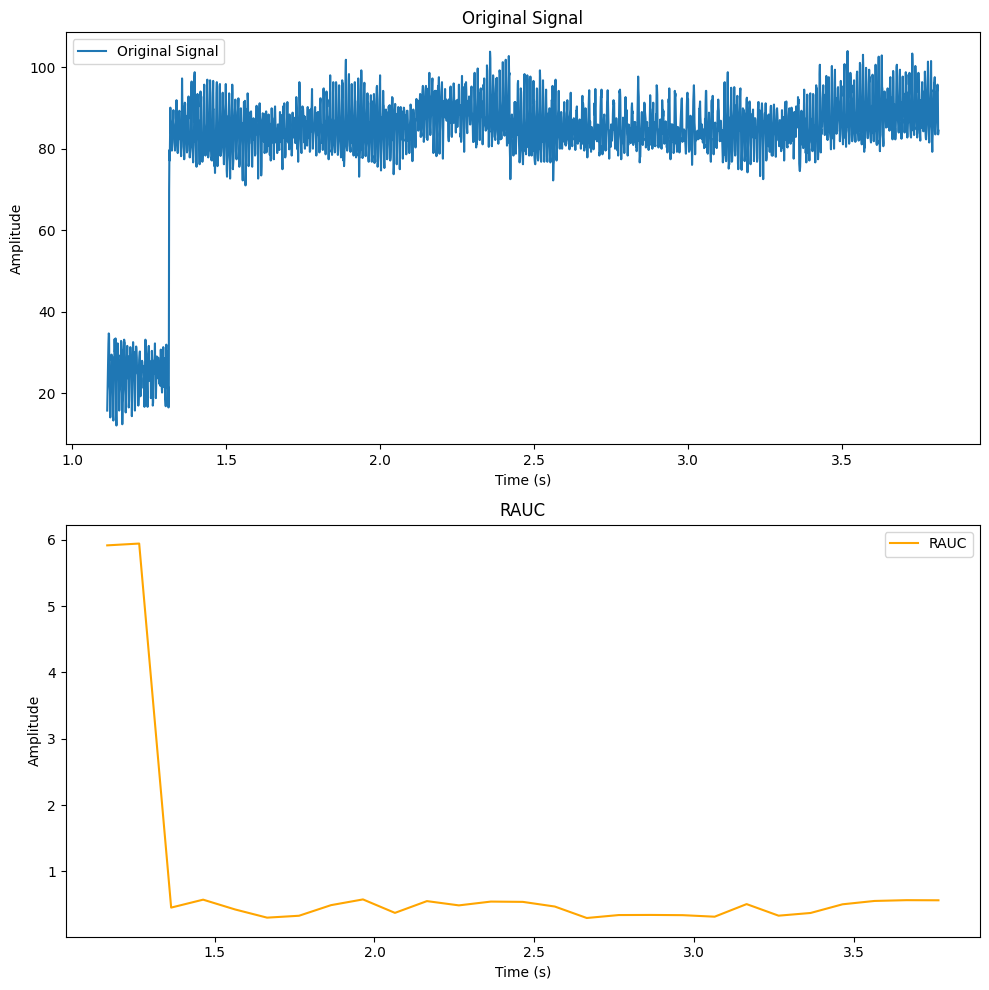

In [214]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot the original signal
axs[0].plot(signal.times, signal, label='Original Signal')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Original Signal')
axs[0].legend()

# Plot the filtered signal
axs[1].plot(derivative_of_signal.times, derivative_of_signal, label='RAUC', color='orange')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('RAUC')
axs[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## 7. Derivative

In this section, we use the `derivative` function to calculate the derivative of the signal. The resulting derivative is then plotted to visualize the rate of change of the signal over time.

In [215]:
signal = signals[:,1]
derivative_of_signal = derivative(signal)

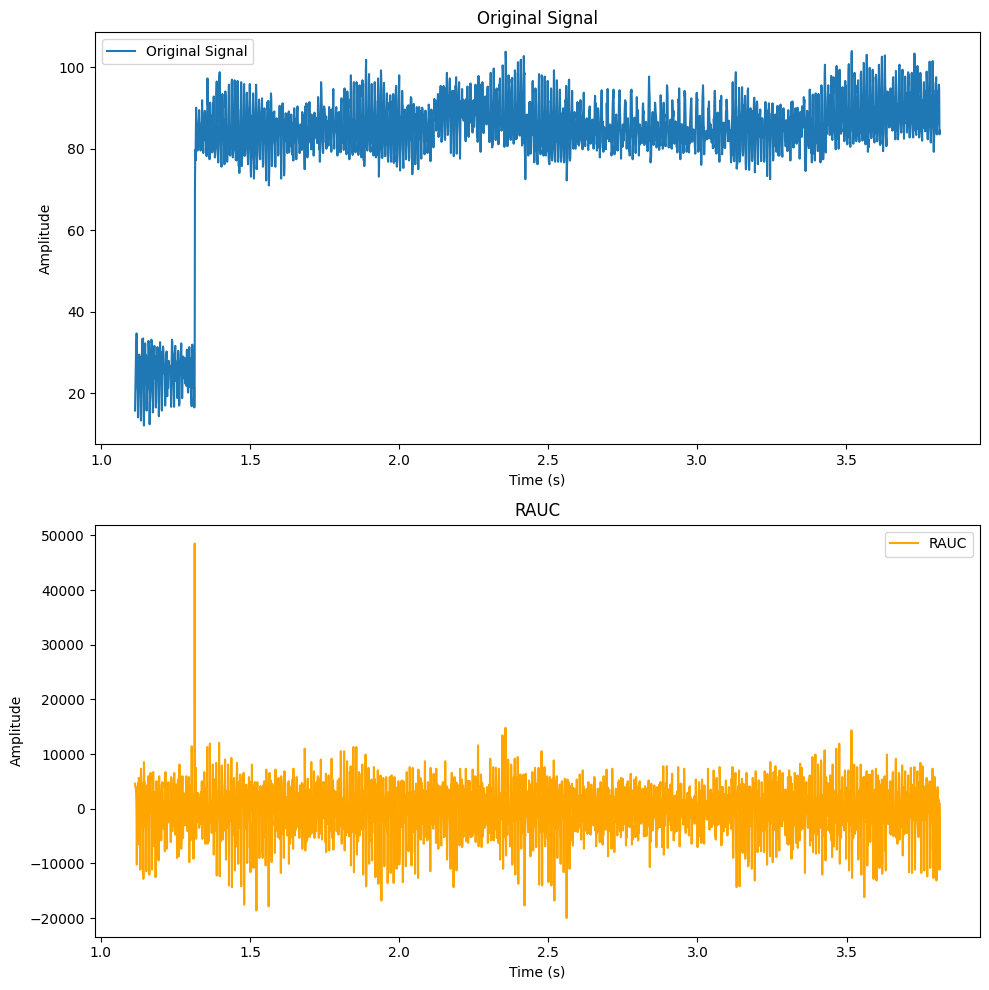

In [216]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot the original signal
axs[0].plot(signal.times, signal, label='Original Signal')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Original Signal')
axs[0].legend()

# Plot the filtered signal
axs[1].plot(derivative_of_signal.times, derivative_of_signal, label='RAUC', color='orange')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('RAUC')
axs[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()